In [1]:
import re
from pathlib import Path

import openai
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ROOT_DIR = Path("..")
OUTPUT_DIR = ROOT_DIR / 'output'
GROBID_DIR = OUTPUT_DIR / 'group_selection_grobid'
SPACY_DIR = OUTPUT_DIR / 'spacy_group_selection_grobid'
CCA_DIR = OUTPUT_DIR / 'cca'

In [2]:
df = pd.read_parquet(CCA_DIR/"groupSel_feud_with_tag.pqt")

### How many words by paragraph parsed by GROBID?

In [3]:
df_count = df.parsed_doc.str.split(" ").map(len).reset_index(name="n")
avg_count = df_count.n.mean()

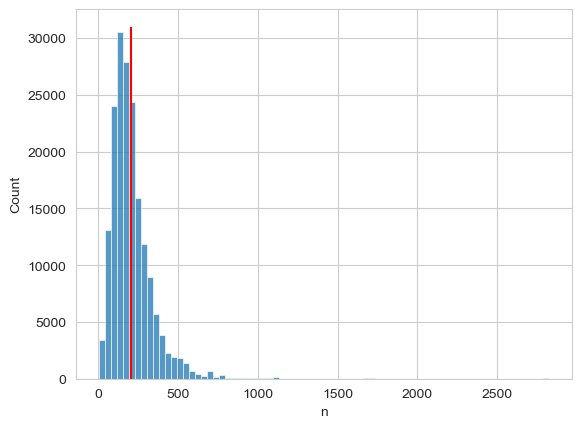

In [4]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1)
sns.histplot(df_count.n, bins=75, ax=ax)
ax.vlines(x=avg_count, ymin=0, ymax=31_000, color="red");

In [5]:
print(f"Avg word count/paragraph: {avg_count}")

Avg word count/paragraph: 205.45425793994275


#### Most common identified authors?

In [6]:
df_count = df.value_counts("cite_spans").reset_index(name="n")

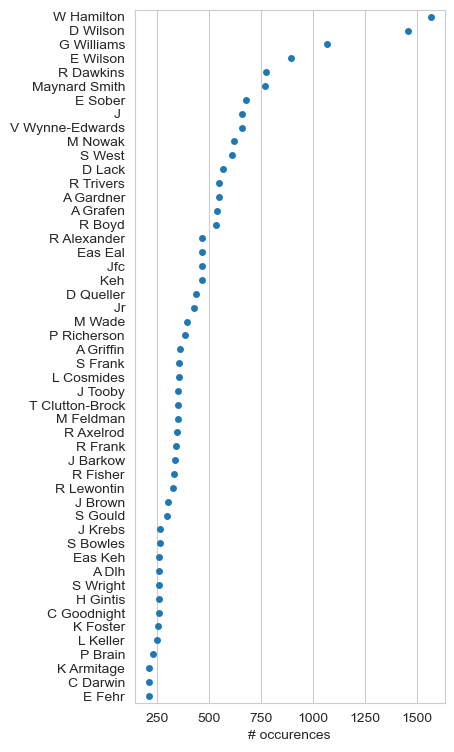

In [7]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(4,9))
sns.stripplot(x="n", y="cite_spans", data=df_count.head(50), ax=ax)
ax.set_ylabel("")
ax.set_xlabel("# occurences");

In [23]:
print(f"There are {len(df.cite_spans.unique())} unique authors")
print(f"On average, people get cited {df_count.n.mean()}")

There are 37838 unique authors
On average, people get cited 4.763148157936466


We note that some authors are junk.

In [38]:
df_count[(df_count.n > 30) & (df_count.cite_spans.str.len() > 2)].cite_spans.to_csv(OUTPUT_DIR / "list_hotshots.csv", index=False)

#### What is the time series of articles and paragraph?

In [49]:
df_count = df[~df.article.duplicated()].value_counts("year").reset_index(name="n")
df_count["year"] = pd.to_datetime(df_count.year, format="%Y")

df_count_par = df.value_counts("year").reset_index(name="n")
df_count_par["year"] = pd.to_datetime(df_count.year, format="%Y")

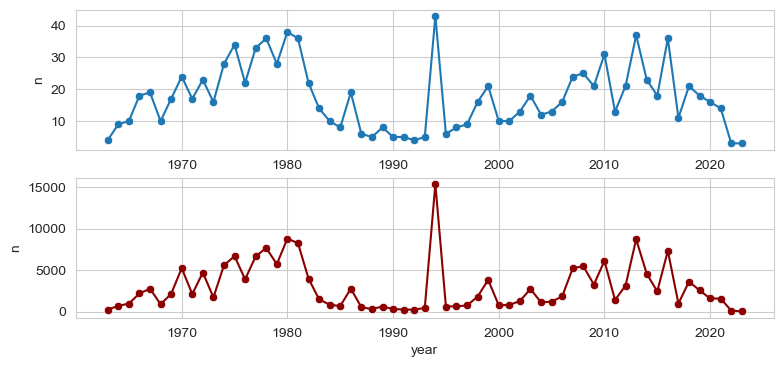

In [54]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9, 4))
sns.scatterplot(x="year", y="n", data=df_count, ax=ax1)
sns.lineplot(x="year", y="n", data=df_count, ax=ax1)

sns.scatterplot(x="year", y="n", color="darkred", data=df_count_par, ax=ax2)
sns.lineplot(x="year", y="n", color="darkred", data=df_count_par, ax=ax2);

#### What is the loglog citation count of authors?

In [78]:
df_count = df[~df.article.duplicated()].value_counts("citationCounts").reset_index(name="n")
df_count['rank'] = df_count.n.rank(ascending=False)

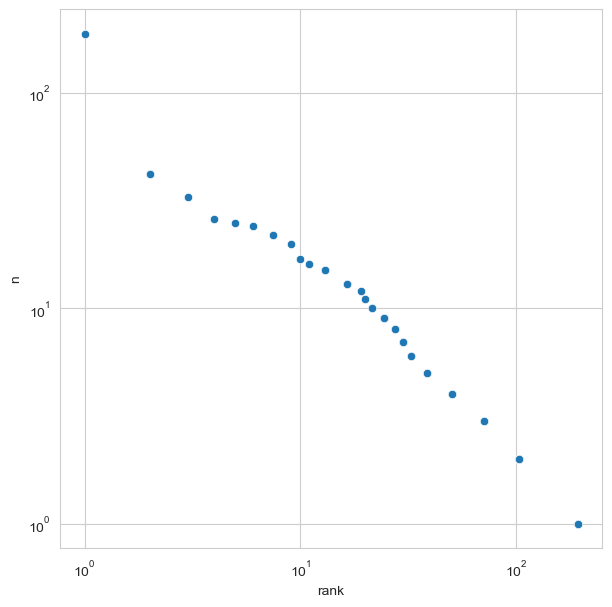

In [114]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(7, 7))
sns.scatterplot(x='rank', y="n", data=df_count, ax=ax)
ax.set_xscale('log')
ax.set_yscale('log');